Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Tensorflow Similarity with Kaggle

[Google Landmark Retrieval 2021](https://www.kaggle.com/c/landmark-retrieval-2021/overview): Given an image, can you find all of the same landmarks in a dataset?

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning quick and easy. 

## Notebook goal

This notebook demonstrates how to use TensorFlow Similarity to train a `SimilarityModel()` for a Kaggle competition and will. 

 1. Show how to efficiently load the Kaggle data from disk.
 
 1. `train()` a similarity model.

 2. `index()` the /index examples.

 3. `calibrate()` the model to estimate what is the best distance theshold to separate matching elements from elements belonging to other classes.

 5. Generate the submission file.

In [2]:
from collections import defaultdict
import csv
from multiprocessing import cpu_count
import os
from pathlib import Path
import random

from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np
from tabulate import tabulate
import tensorflow as tf
from tqdm.auto import tqdm

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import RandAugment
from tensorflow_similarity.architectures import EfficientNetSim
from tensorflow_similarity.losses import MultiSimilarityLoss
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

In [5]:
tf.get_logger().setLevel('ERROR')  # silence TF warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # silence remaining TF warnings
tfsim.utils.tf_cap_memory()

In [6]:
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.6.0
TensorFlow Similarity 0.14.8


# Functions and variables

In [7]:
NUM_IMGS = 1580470
IMG_SIZE = 320
CLASSES_PER_BATCH = 16  # batch size = CLASSES_PER_BATCH* 2
NUM_LANDMARKS = 203092
NUM_VAL_LANDMAKRS = 300

CPU_COUNT = cpu_count()
print("NUM CPU:", CPU_COUNT)

NUM CPU: 8


In [8]:
def plot_25(x, y):
    """Plot the first 25 images."""
    num_cols = num_rows = 5
    fig = plt.figure(figsize=(6.0, 6.0))
    grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

    for ax, im, label in zip(grid, x, y):
        ax.imshow(im)
        ax.axis("off")
    
def load_img(img_path):
    "Load image from disk and resize it"
    img = tf.io.read_file(img_path)
    img =  tf.io.decode_image(img)
    return tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)

# Data preparation

The following section loads the test data into index and query splits as np.arrays. This will be used later to calibrate and test the model.

NOTE: these data sets are large and the following cells have been optimized to improve the loading speed.

In [9]:
data_path = Path('../tmp/landmark-retrieval-2021')

# Sample a random set of landmark IDs for validation
val_lmk_idxs = random.sample([i for i in range(NUM_LANDMARKS)], k=NUM_VAL_LANDMAKRS)

In [10]:
x_train_img_path = []
y_train = []
x_test_img_path = []
y_test = []
testlmk2id = {}
pb = tqdm(total=NUM_IMGS, desc="loading images path")

with open(data_path / 'train.csv') as csvfile:
    # pathlib is slow while looping
    data_path_str = str(data_path)
    
    # reader is faster than DictReader
    reader = csv.reader(csvfile) 
    next(reader) # drop the header
    
    for row in reader:
        # compute path to img
        slug = [row[0][i] for i in range(3)]
        img_path = os.path.join(data_path_str, 'train', *slug, f"{row[0]}.jpg")
    
        # add img either in validation or testing
        class_idx = int(row[1])
        if class_idx in val_lmk_idxs:
            y_test.append(class_idx) 
            x_test_img_path.append(img_path) 
            testlmk2id[class_idx] = len(testlmk2id)   
        else:
            y_train.append(class_idx)            
            x_train_img_path.append(img_path)
        pb.update()        
pb.close()

print("train size", len(x_train_img_path))
print("test size", len(x_test_img_path))

loading images path:   0%|          | 0/1580470 [00:00<?, ?it/s]

train size 1578351
test size 2119


## Prepare validation

In [11]:
# load validation image in memory
x_test = []
for img_path in tqdm(x_test_img_path):
    img = load_img(img_path)
    x_test.append(img)
    
x_test = np.array(x_test)
y_test = np.array(y_test)

  0%|          | 0/2119 [00:00<?, ?it/s]

## Visualize the dataset

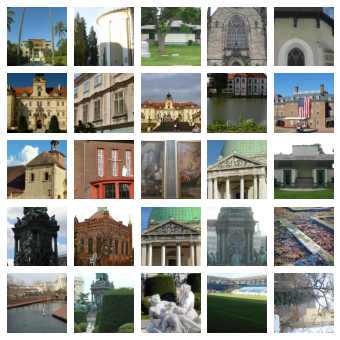

In [12]:
# Plot 25 random examples.
x_imgs = []
y_imgs = []
for idx in random.sample(range(len(x_test)), k=25):
    x_imgs.append(x_test[idx])
    y_imgs.append(y_test[idx])
    
plot_25(x_imgs, y_imgs)

## Create index and query splits

In [13]:
IMG_PER_CLASS = 1
index = defaultdict(list)
x_index = []
y_index = []
x_query = []
y_query = []

for idx in range(len(x_test)):
    class_idx = testlmk2id[y_test[idx]]
    img = x_test[idx]
    if len(index[class_idx]) < IMG_PER_CLASS:
        index[class_idx].append(img)
        x_index.append(img)
        y_index.append(class_idx)        
    else:
        x_query.append(img)
        y_query.append(class_idx)


x_index = np.array(x_index)
y_index = np.array(y_index)
x_query = np.array(x_query)
y_query = np.array(y_query)

## Prepare training

The `Tensorflow Similarity` models expect a Dataset Sampler to ensure that each batch contains at least 2 examples of each class in the batch.

Here we are passing a `Callable` as the augmenter in the `MultiShotMemorySampler()`. This function will take in the image paths and then load, decode, reshape, crop, and apply a random augmentation. 

This enables us to load all the train image paths into memory, but only load a single batch of images at a time.

In [14]:
# read each image from disk and construct the batch as "augment function" to 
# sampler
@tf.function()
def process(img):
    augmenter = RandAugment()
    img = tf.io.decode_image(img)
    if tf.shape(img)[0] < IMG_SIZE or tf.shape(img)[1] < IMG_SIZE:
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)
    img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
    img = augmenter.distort(img)
    return img

def loader(x, y, sample_per_batch, is_warmup):
    imgs = []
    for img_path in x:
        imgs.append(tf.io.read_file(img_path))
    imgs = tf.stack(imgs)
    imgs = tf.map_fn(process, 
                     imgs, 
                     parallel_iterations=CPU_COUNT,
                     dtype='uint8')

    return imgs, y

In [15]:
train_ds = MultiShotMemorySampler(x_train_img_path, y_train,
                                  classes_per_batch=CLASSES_PER_BATCH,
                                  augmenter=loader)


The initial batch size is 32 (16 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/1578351 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/81202 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1578351 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1578351 [00:00<?, ?it/s]

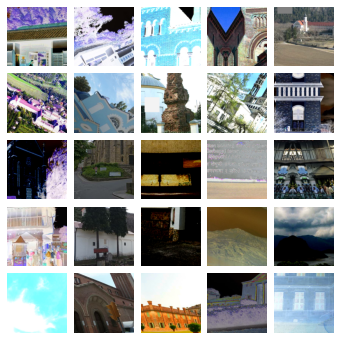

In [16]:
x_batch, y_batch = train_ds.generate_batch(1)
plot_25(x_batch, y_batch)

# Build and train

The following uses the EfficientNet as the backbone of the model and trains using `MutliSimilarityLoss()` for 10 epochs.

In [17]:
embedding_size = 256
model = EfficientNetSim((IMG_SIZE, IMG_SIZE, 3), embedding_size=embedding_size, augmentation=None)
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
metric_embedding (MetricEmbe (None, 256)               327936    
Total params: 4,377,507
Trainable params: 327,936
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
epochs = 10
loss = MultiSimilarityLoss(distance='cosine')
model.compile('adam', loss=loss)
history = model.fit(train_ds, epochs=10, validation_data=(x_test, y_test))

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/10
1000/1000 [==============================] - 359s 351ms/step - loss: 1.0219 - val_loss: 1.0110
Warmup complete
Epoch 2/10
1000/1000 [==============================] - 328s 328ms/step - loss: 1.0051 - val_loss: 1.0030
Epoch 3/10
1000/1000 [==============================] - 287s 286ms/step - loss: 1.0000 - val_loss: 0.9896
Epoch 4/10
1000/1000 [==============================] - 280s 280ms/step - loss: 0.9979 - val_loss: 0.9856
Epoch 5/10
1000/1000 [==============================] - 277s 277ms/step - loss: 0.9970 - val_loss: 0.9880
Epoch 6/10
1000/1000 [==============================] - 277s 277ms/step - loss: 0.9926 - val_loss: 0.9920
Epoch 7/10
1000/1000 [==============================] - 272s 272ms/step - loss: 0.9938 - val_loss: 0.9795
Epoch 8/10
1000/1000 [==============================] - 267s 267ms/step - loss: 0.9912 - val_loss: 0.9893
Epoch 9/10
1000/1000 [==============================] - 26

In [ ]:
model.save(data_path / "models" / "kaggle")

In [ ]:
model = tf.keras.models.load_model(data_path / "models" / "kaggle")

# Calibration

## Create calibration index

We can calibrate a distance threshold using a matching strategy and a calibration metric. Calibration requires creating an index, so here we load the x_index and y_index subset that we created when loading the training data.

In [70]:
model.reset_index()
model.index(x=x_index, y=y_index, data=x_index)

[Indexing 121 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


## Find distance threshold

Here we are searching for the optimal F1 score while using K=1 as our classifier. All matches at or below the calibrated threshold distance will be labeled as a Positive match between the query example and the label associated with the match result, while all matches above the threshold distance will be labeled as a Negative match.

Additionally, `model.calibrate()` returns a `CalibrationResults` object that can be used to plot and evaluate the metrics. The calibration object contains the following fields:

* "cutpoints": A Python dict mapping the cutpoint name to a dict containing the `ClassificationMetric` values associated with a particular distance threshold, e.g., "optimal" : {"acc": 0.90, "f1": 0.92}.
* "thresholds": A Python dict mapping `ClassificationMetric` names to a list containing the metric's value computed at each of the distance thresholds, e.g., {"f1": [0.99, 0.80], "distance": [0.0, 1.0]}.


In [71]:
calibration = model.calibrate(x_query, y_query)


Performing NN search



Building NN list:   0%|          | 0/1697 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/1696 [00:00<?, ?it/s]


 name       value    distance    precision    recall        f1
-------  -------  ----------  -----------  --------  --------
optimal     0.62    0.259791     0.444313         1  0.615259


## Metrics plots

The following plots show the change in the classification metrics over as the distance changes.

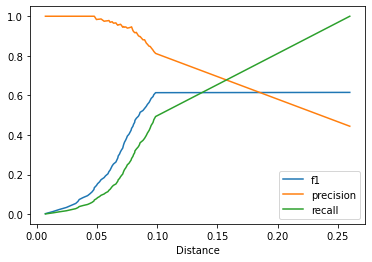

In [94]:
fig, ax = plt.subplots()
x = calibration.thresholds['distance']
ax.plot(x, calibration.thresholds['f1'], label='f1')
ax.plot(x, calibration.thresholds['precision'], label='precision')
ax.plot(x, calibration.thresholds['recall'], label='recall')
ax.set_xlabel('Distance')
ax.legend()
plt.show()

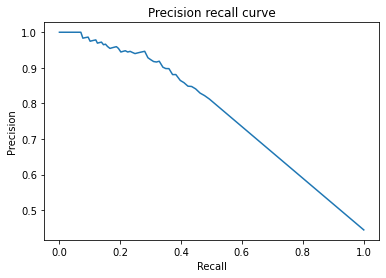

In [73]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds['recall'], calibration.thresholds['precision'])
ax.set_title("Precision recall curve")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

# Submission code

## Index data

We need to create the index in order to create the submission file. Tensorflow similarity enables users to batch add the index examples using the `model.index()` method. 

The following cell loads the index dataset img paths and then constructs batches of images and image IDs.

In [89]:
BATCH_SIZE = 64
test_path = data_path / 'index' 
index_imgs_path = list(test_path.glob('**/*.jpg'))
total_imgs = len(index_imgs_path)
total_imgs = 1000  # remove to index the whole dataset 70k images

# reset the index
model.reset_index()

# indexing
pb = tqdm(total=total_imgs, desc="indexing images")
for idx in range(0, total_imgs, BATCH_SIZE):
    imgs = []
    img_ids = []
    
    # construct the batch
    for i in range(idx, idx + BATCH_SIZE):
        img_path = index_imgs_path[i]
        imgs.append(load_img(str(img_path)))
        img_ids.append(img_path.stem)
        pb.update()
        
    # add the batch to the index
    model.index(np.array(imgs), data=img_ids, verbose=0)
pb.close()

indexing images:   0%|          | 0/1000 [00:00<?, ?it/s]

## Match test images

Next we need to find the K nearest neighbors in the index for each image in the test dataset. The competition asks for the 100 nearest neighbors, but here we return the 10 nearest to keep the example simple.

Each query returns a list of `Lookup` object. For each list, we unpack the image ID stored in the `Lookup.data` field and then map the query image ID to the set of `Lookup` image IDs.

In [92]:
BATCH_SIZE = 64
k = 10  # competition assume k == 100 - using 10 for demo purpose.
results = defaultdict(list)
test_path = data_path / 'test' 
test_imgs_path = list(test_path.glob('**/*.jpg'))
total_imgs = len(index_imgs_path)
total_imgs = 1000  # remove to index the whole dataset 70k images

# indexing
pb = tqdm(total=total_imgs, desc="matching images")
for idx in range(0, total_imgs, BATCH_SIZE):
    query_imgs = []
    query_img_ids = []
    
    # construct the batch
    for i in range(idx, idx + BATCH_SIZE):
        img_path = test_imgs_path[i]
        query_imgs.append(load_img(str(img_path)))
        query_img_ids.append(img_path.stem)
        pb.update()
        
    # retrieve the KNN 
    match_sets = model.lookup(np.array(query_imgs), verbose=0)
    
    # map the query image ID to the set of neighbor img IDs 
    for query_img_id, match_set in zip(query_img_ids, match_sets):
        results[query_img_id] = [lookup.data for lookup in match_set]
pb.close()        

matching images:   0%|          | 0/1000 [00:00<?, ?it/s]

## Check data

The competition requires the data to be a two column CSV consisting of the query image ID and a space separated string representing the matching image IDs.

Here we print out the first 10 rows and verify the formatting.

In [76]:
rows = [[k, " ".join(v)] for k, v in results.items()]
print(tabulate(rows[:10], headers=['id', 'images'], tablefmt='csv'))

id                images
----------------  ------------------------------------------------------------------------------------
8890929c27318d2b  83dc9da13cbefc56 8851b7b761f6bceb 8fbb1f0a6d399698 89271145c6c712aa 89a40c6e9a8d92f3
88ec81deb52a3df6  831c594fa2bf76ff 887a8ce794a4612b 8ff95f1f2a6d3541 88ea1bef00b88f89 83f08a0b9fb4a4d2
88471a39dac8ac43  8f3ef5a17744ad54 838e63e70fa2042b 88513252f27ea430 88288e76d7e21127 89499172cc9f7d30
88c00cecf7a76f74  889c9e4478a393be 8947db7bae83c9ff 8999fb5932247903 880b4d60f13166f7 83f7160bc4e11b52
8821cb4b5330b189  889c9e4478a393be 894033411a0ca27f 881fe87298ebb17d 880b4d60f13166f7 83d1b37aa0b92f3e
8982b9bdab72d897  889c9e4478a393be 880b4d60f13166f7 8947db7bae83c9ff 83b1e00da7b8b448 8f9e018e4f3c49d8
89b12ae28e5f957a  8342fae57547f4cb 8947db7bae83c9ff 89b9cbdbc3e58cfc 889c9e4478a393be 8f9e018e4f3c49d8
8380babca9f46d53  8999fb5932247903 8894d9c17c282ad8 833c55bf2b450ae1 83ddca847718d1ad 8f33a194af43f731
83f2225112c40910  8352d91f91dddda2 89f1901b31abd

## Write submission file

Finally, we write the results to disk.

In [91]:
with open(data_path / 'submission.csv', 'w+', newline='', encoding='utf-8') as out:
    writer = csv.writer(out)
    writer.writerow(['id', 'images'])
    writer.writerows(rows)